In [124]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial.distance import euclidean
import skimage

In [125]:
def calculate_starGT(instance_segmentation_map, n_rays = 8):
        """
        Calculate object prob for each pixel in the image.
        Args:
        - instance_segmentation_map: A 2D numpy array representing the instance segmentation map.
        - n_rays: The number of rays to sample for each instance.
        Returns:
        - object_probabilities: A 2D numpy array of the same shape as the input image with object probabilities.
        - star_distances: A 3D numpy array of shape (H, W, n_rays) with distances to the n_rays star points.
        - angles: A 3D numpy array of shape (H, W, n_rays) with angles to the n_rays star points.
        """

        # init the object probs with zeros
        object_probabilities = np.zeros_like(instance_segmentation_map, dtype=float)
        star_distances = np.zeros((instance_segmentation_map.shape[0],instance_segmentation_map.shape[1],n_rays), dtype=float)
        angles = np.zeros_like(star_distances, dtype=float)
        # iterate over each instance
        for inst in np.unique(instance_segmentation_map)[1:]:
            instance_pixels = (instance_segmentation_map == inst)
            boundary_pixels = skimage.segmentation.find_boundaries(instance_pixels, 2, mode='inner', background=0)
            boundary_indices = np.argwhere(boundary_pixels)
            # randomly sample n_rays points on the boundary
            n_boundary_pixels = boundary_indices.shape[0]
            try:
                ray_indices = np.random.choice(n_boundary_pixels, size=n_rays, replace=False)
            # if there are less boundary pixels than rays, sample with replacement
            except:
                ray_indices = np.random.choice(n_boundary_pixels, size=n_rays, replace=True)

            ray_points = boundary_indices[ray_indices]
            # iterate over each pixel in the instance
            for i in range(instance_segmentation_map.shape[0]):
                for j in range(instance_segmentation_map.shape[1]):
                    if instance_pixels[i,j]:
                        distances_to_background = np.linalg.norm(
                        boundary_indices - np.array([i, j]), axis=1
                        )
                        min_distance = np.min(distances_to_background)
                        # normalize to [0, 1]
                        try:
                            object_probabilities[i, j] = min_distance / distances_to_background.max()
                        except:
                            object_probabilities[i, j] = 0
                        # calculate the distance from instace pixel to each ray point using np.linalg.norm
                        star_distances[i,j] = np.linalg.norm(ray_points - np.array([i, j]), axis=1)
                        # calc the angles with respect to the x-axis
                        angles_ray = np.arctan2(ray_points[:, 1] - j, ray_points[:, 0] - i)
                        # angles from [-pi,pi] --> [0, 2pi] and normalize to [0, 1]
                        angles[i,j] = ((angles_ray + 2 * np.pi) % (2 * np.pi)) / (2 * np.pi)               
        return object_probabilities, star_distances, angles 

In [126]:
labels_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/labels.npy"
images_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/images.npy"

instance_map = np.load(labels_path)[1,:,:,0]
image = np.load(images_path)[1,:,:,0]

In [127]:
instance_map.shape

(256, 256)

In [128]:
object_probabilities, star_distances, angles  = calculate_starGT(instance_map, n_rays = 8)

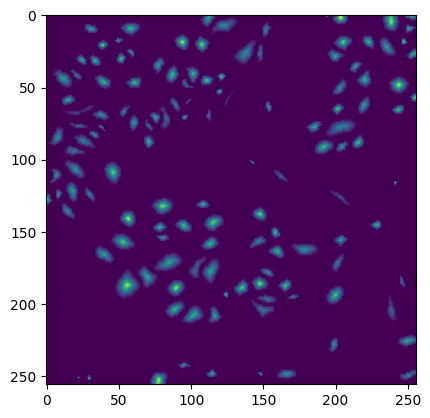

In [129]:
plt.imshow(object_probabilities)

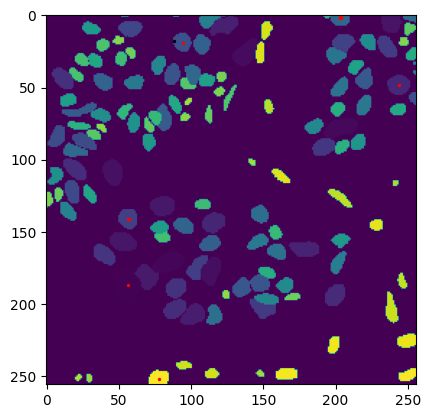

In [130]:
# select points where object_probabilities > 0.72
points = np.argwhere(object_probabilities > 0.65)
plt.imshow(instance_map)
plt.scatter(points[:,1], points[:,0], s=2, c='r')
plt.scatter(88,18,s=2, c='black')
plt.show()

In [150]:
print(star_distances[19,94])
print(angles[19,94])

[6.08276253 5.         6.40312424 6.08276253 5.38516481 5.65685425
 6.         5.83095189]
[0.52628423 0.89758362 0.60738836 0.47371577 0.43944053 0.125
 0.5        0.91398957]


In [133]:
angles.shape

(256, 256, 8)

In [134]:
import numpy as np

def calculate_endpoint(start_point, length, angle_rad):
    x_start, y_start = start_point
    delta_x = length * np.cos(angle_rad)
    delta_y = length * np.sin(angle_rad)
    x_end = x_start + delta_x
    y_end = y_start + delta_y
    return x_end, y_end

start_point = np.array([141,  56])
length = star_distances[start_point[0], start_point[1]]
angle_rad = angles[start_point[0], start_point[1]] * 2 * np.pi
x , y = calculate_endpoint(start_point, length, angle_rad)
print(x,y)

[147. 146. 144. 139. 135. 146. 139. 146.] [54. 61. 51. 50. 57. 54. 51. 53.]


[[  0 194]
 [ 10  31]
 [ 10 251]
 [ 22 235]
 [ 29 200]
 [ 31  24]
 [ 35 214]
 [ 53 120]
 [ 62 220]
 [ 71  76]
 [ 91 204]
 [116 241]
 [122  18]
 [156 203]
 [166  40]
 [178 113]
 [194 124]
 [226 249]
 [251  22]]


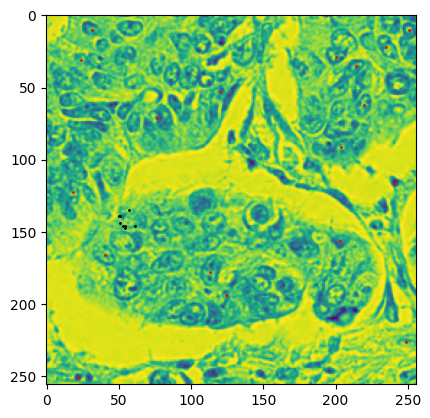

In [145]:
# calculate 99.5 percentile object_probabilities
percentile_99_5 = np.percentile(object_probabilities, 99.5)
# select points whcih are atleast 5 pixels away from each other
def filter_points(points, x):
    filtered_points = []
    
    for i, point1 in enumerate(points):
        is_valid = True
        
        for j, point2 in enumerate(points):
            if i != j:  # Avoid comparing the point to itself
                distance = np.linalg.norm(np.array(point1) - np.array(point2))
                if distance < x:
                    is_valid = False
                    break  # No need to check other points
                
        if is_valid:
            filtered_points.append(point1)
    
    return np.array(filtered_points)

# select points where object_probabilities > percentile_99.5
mid_points = np.argwhere(object_probabilities > percentile_99_5)
# filter points
filtered_points = filter_points(mid_points, 5)
plt.imshow(image)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y,x,s=1, c='black')
plt.show()

In [154]:
# print(star_distances[10 , 31])
# print(object_probabilities[10 , 31])
# print(star_distances[22 , 235])
# print(object_probabilities[22 , 235])
print(star_distances[10 , 31])
print(star_distances[22 , 235])

[4.12310563 3.60555128 3.16227766 4.47213595 3.         6.
 6.         3.16227766]
[6.40312424 7.28010989 6.         7.07106781 7.61577311 4.24264069
 5.38516481 6.        ]


In [169]:
star_d = (star_distances[filtered_points[:,0],filtered_points[:,1]])
star_theta = (angles[filtered_points[:,0],filtered_points[:,1]] * 2 * np.pi)
delta_x = star_d * np.cos(star_theta)
delta_y = star_d * np.sin(star_theta)
x_end = filtered_points[:,0].reshape(-1,1) + delta_x
y_end = filtered_points[:,1].reshape(-1,1) + delta_y

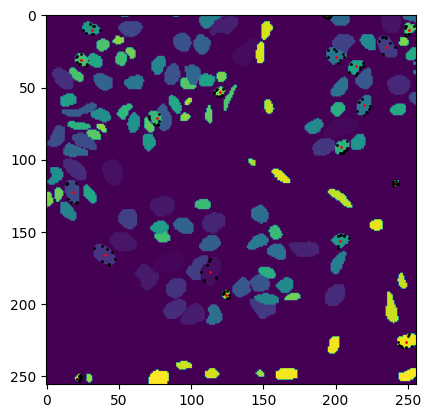

In [170]:
plt.imshow(instance_map)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y_end,x_end,s=1, c='black')




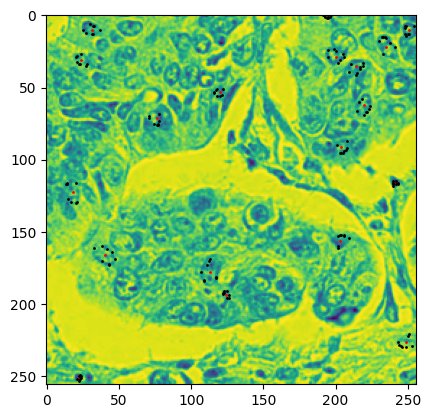

In [171]:
plt.imshow(image)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y_end,x_end,s=1, c='black')

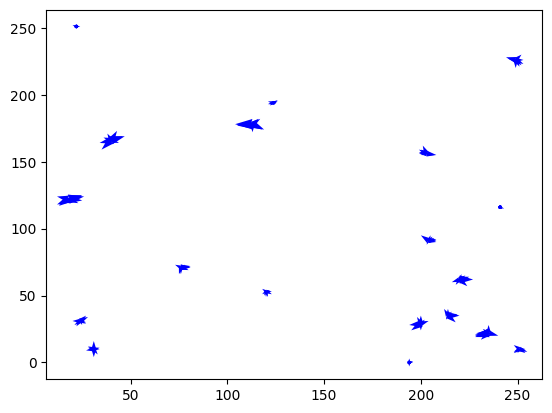

In [194]:
fig, ax = plt.subplots()

for i in range(len(filtered_points)):
    for j in range(8):
        ax.quiver(filtered_points[i,1], filtered_points[i,0], delta_x[i,j], delta_y[i,j], angles='xy', scale_units='xy', scale=1, color='b')

In [177]:
filtered_points

array([[  0, 194],
       [ 10,  31],
       [ 10, 251],
       [ 22, 235],
       [ 29, 200],
       [ 31,  24],
       [ 35, 214],
       [ 53, 120],
       [ 62, 220],
       [ 71,  76],
       [ 91, 204],
       [116, 241],
       [122,  18],
       [156, 203],
       [166,  40],
       [178, 113],
       [194, 124],
       [226, 249],
       [251,  22]])

In [187]:
x_end[1]

array([ 6.,  7.,  7., 12., 13., 10., 10., 13.])

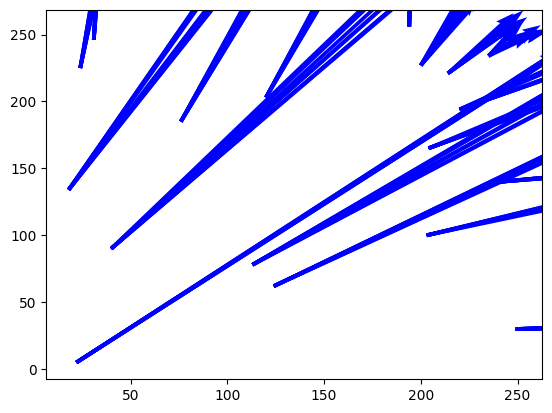

In [188]:
fig, ax = plt.subplots()
y, x = np.shape(image)
for i in range(len(filtered_points)):
    for j in range(8):
        ax.quiver(filtered_points[i,1], y - filtered_points[i,0], x_end[i,j], y - y_end[i,j],angles='xy', scale_units='xy', scale=1, color='b')

In [198]:
import cv2 as cv

In [240]:
# create a blob of 1s in a 2D array
img = np.zeros((100, 100))
img[40:45, 60:65] = 1

coutours, _ = cv.findContours(img.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

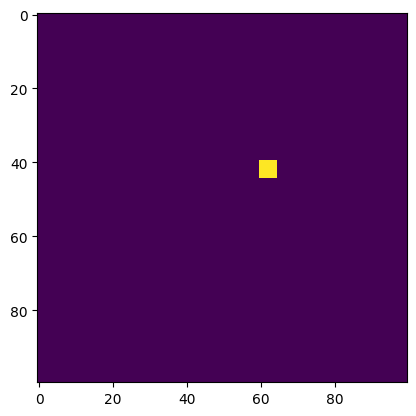

In [241]:
plt.imshow(img)

In [242]:
coutours[0]

array([[[60, 40]],

       [[60, 41]],

       [[60, 42]],

       [[60, 43]],

       [[60, 44]],

       [[61, 44]],

       [[62, 44]],

       [[63, 44]],

       [[64, 44]],

       [[64, 43]],

       [[64, 42]],

       [[64, 41]],

       [[64, 40]],

       [[63, 40]],

       [[62, 40]],

       [[61, 40]]], dtype=int32)

In [244]:
result = []
for i in range(100):
    for j in range(100):
        if img[i,j] == 1:
            # find the index in the coutours list where x cordinate is i
            index = np.where(coutours[0][:,0,0] == i)[0]
            max_y = np.argmax(coutours[0][index,0,1])
            out = (index[max_y])
            result.append(out)

ValueError: attempt to get argmax of an empty sequence

In [233]:
print(len(coutours[0]))
len(result)


20


36

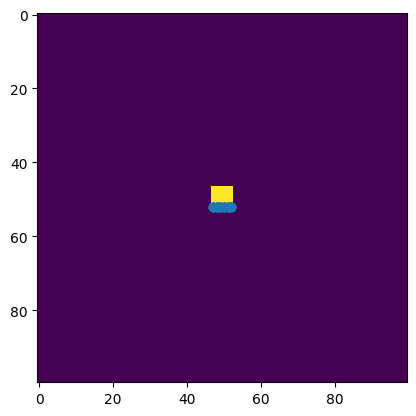

In [237]:
x = coutours[0][result][:,:,0]
y = coutours[0][result][:,:,1]
plt.imshow(img)
plt.scatter(x,y)